# Calculating optimal aperture

Choosing the wrong aperture when doing photometry can lead to misleading results and/or even to miss completely the variability/information you are looking for. Let's see what are the steps to find the optimal aperture for your data.

In [3]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus
import astropy.io.fits as pf
import numpy as np
from matplotlib import pyplot as plt

/tmp/ipykernel_7200/2461215703.py:3: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, aperture_photometry, CircularAnnulus
/tmp/ipykernel_7200/2461215703.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import CircularAperture, aperture_photometry, CircularAnnulus
/tmp/ipykernel_7200/2461215703.py:3: DeprecationWarning: `photutils.CircularAnnulus` is a deprecated alias for `photutils.aperture.CircularAnnulus` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAnnulus` to silence this warni

In [4]:
# filename = 'rfinalMCT21_1803120162.fits'
filename = 'V1_img_calib.fits'
image = pf.getdata(filename)

We now have to define the positions of our stars as: (x1, y1), (x2, y2)...
Of course, if you just want to have one star, that is fine.
You also have the option of defining positions using RA and Dec and then using astropy to convert them to x,y units (check the photutils tutorial for that or ask me if you need help)

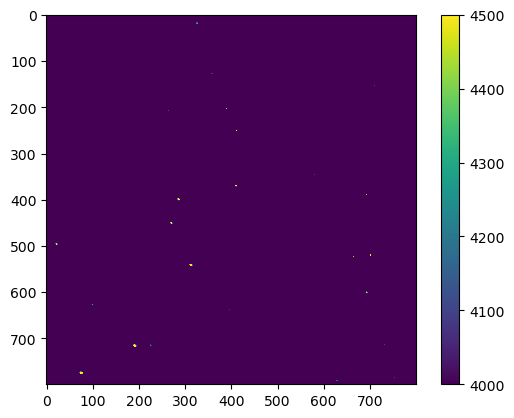

In [34]:
pixel_values = image
plt.imshow(pixel_values, vmin=4000, vmax=4500)
plt.colorbar()

In [5]:
# positions = [(625.34, 507.22), (367.93, 802.57)]
# positions = [(370.955, 412.163)]
positions = [(412.163, 370.955)]

Let's plot the profile of one of the stars!

We need to remove the decimals and very important "invert the axis" so we actually have the profile of our star.
One way to know if you are doing it right/wrong is that the 2-D star profile should be pretty much in the middle of the graph. If you see a profile skewed to one side or no star at all, then check your axis in the plot command.

We will add a few pixels to the left/right of one of the axis to be able to see the full 2-D profile. Which axis you choose should not be too revelant. It just means you are cutting through the star in the x or y axis.

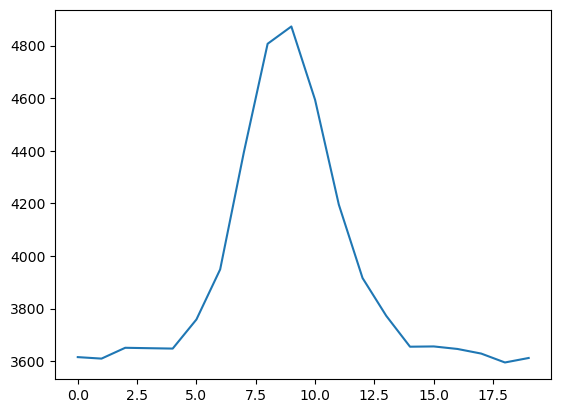

In [6]:
plt.plot(image[371, 412-10:412+10])
plt.show()

Note that saturated stars (like this one above) show a profile cut on the top. This shows that we have lost information for that star and we should not use it at all! --> you cannot measure properly its brightness or its full width half maximum.

On the other hand, a non saturated star (like the second one, see profile below) shows a Gaussian-like curve (although not really Gaussian)

Did you noticed that regardless of the brightness the width of the profile is quite similar? 

The saturated one looked bigger on the DS9 image, right? That's just because you were blowing out the star to see the image better. Within the same sky conditions, all stars would have a similar PSF or Point Spread Function. The main difference will be the hight of their profile (a.k.a. brightness of the star)

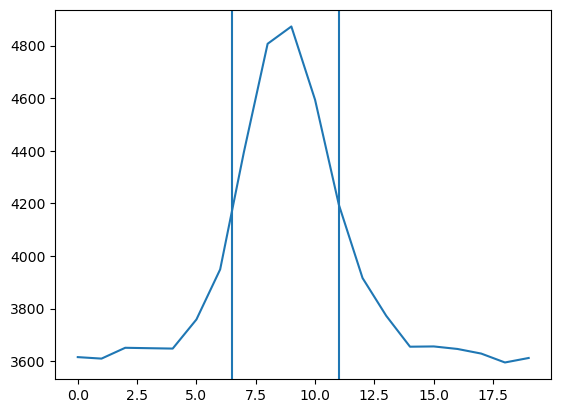

In [7]:
plt.plot(image[371, 412-10:412+10])
plt.axvline(x=6.5)
plt.axvline(x=11.0)
plt.show()

#### What is the best aperture?

Simple. The one that maximises the signal to noise of your star (the one you want to study).

The best aperture tends to be quite close to the full with half maximum of the profile curve of stars (shown by the vertical lines in the previous profile).

The signal lost on the tails of the star is not significant since it does not improves the signal to noise.

##### Very important, once you find the right aperture for your target, all the other stars in your field must have the same aperture.

This means that the reference stars should be at least as bright as your source so their signal to noise is not worse than that of your target --> this is very important in the case of differential photometry (more on this in the next tutorial).

Ok! let's find out an optimal way to find out the right aperture for each image

Since the seeing (FWHM x pixel scale) is constantly changing, we will need to calculate the right aperture for each image.

### Calculating the signal to noise ratio

\begin{equation}
SNR = \dfrac{N^{net}_{star}}{\sqrt{N^{net}_{star}+N_{sky}+N_{noise}}}
\end{equation}

where $N^{net}_{star}$ is the net counts from your star (that is background subtrackted), $N_{sky}$ the number of background counts in the same area as the star and $N_{noise}$ the readout noise (normally given in the fits header and can be assumed 0 in most cases).

###### Let's do the aperture photometry without optimisation

We start by defining the type and size of our aperture. Let's do it circular.

Note that I am using positions[1] so we do photometry only on the start not saturated.

You could run this command with just positions and do photometry and both stars simulataneously

In [8]:
aperture = CircularAperture(positions[0], r=3.)

We then do aperture photometry and display the table with the results.

In [9]:
phot_table = aperture_photometry(image, aperture)
phot_table['aperture_sum'].info.format = '%.8g'
print(phot_table)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1 412.163 370.955    117887.88


But we have not takeng into account the background!

Let's measure the background as an annulus around the star.

As you can see we have defined a variable called "apers" that contains the apertures of the star and the background.

Let's repeat the photometry process but this time including the background

In [10]:
annulus_aperture = CircularAnnulus(positions[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id xcenter ycenter aperture_sum_0 aperture_sum_1
      pix     pix                                
--- ------- ------- -------------- --------------
  1 412.163 370.955      117887.88      922261.84


The first aperture was the one for the source and thus on the table 'aperture_sum_0' corresponds to the star and 'aperture_sum_1' to the background

Note that the background was measured using an aperture of different shape and size, so at the moment is meaningless.

We will calculate the background per pixel (bkg_mean) and then the total background in an area equivalent to the star (bkg_total).

Then we can measure the net counts for our star(s)

In [11]:
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
print(net_star)

aperture_sum_0
--------------
     15414.344


We have now all the elements to calculate the signal-to-noise ratio of our source.

In [12]:
snr = net_star / np.sqrt(net_star + bkg_total)
print(snr)

aperture_sum_0
--------------
     44.894225


Is this the best SNR there is?

Let's try a different aperture and see what happens with the SNR (this is a good moment to start thinking of creating a function with all these steps so you can do all this in essentailly one line)

### Let's work now on the optimisation

In general, you can run multiple apertures at once

In [13]:
radii = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
apertures = [CircularAperture(positions[0], r=r) for r in radii]
phot_table = aperture_photometry(image, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id xcenter ycenter ... aperture_sum_7 aperture_sum_8 aperture_sum_9
      pix     pix   ...                                             
--- ------- ------- ... -------------- -------------- --------------
  1 412.163 370.955 ...      753098.67      946793.85      1163349.7


For simplicity here, let's assume the background per pixel (bkg_mean) we calculated before is still valid since I used an annulus that was larger than the largest radius included in here

Always calculate the background using an annulus that is bigger than your largest aperture

We could have also created a similar parameter to "apers" where we would have all the apertures for the star and one extra one for the background.

From the "phot_table", the first 3 columns are id, x and y. So we don't need them in the next step. If you would have done the background calculation in here as well, the last column of all would be the background and thus, in the for loop below you should have stopped before that column.

In [14]:
snr = np.array([])
index = 0
for col in phot_table.colnames[3:]:
    bkg_total = bkg_mean * apertures[index].area
    net_star = phot_table[col] - bkg_total
    snr = np.append(snr, net_star / np.sqrt(net_star + bkg_total))
    index += 1

Let's plot now the evolution of the SNR vs aperture.

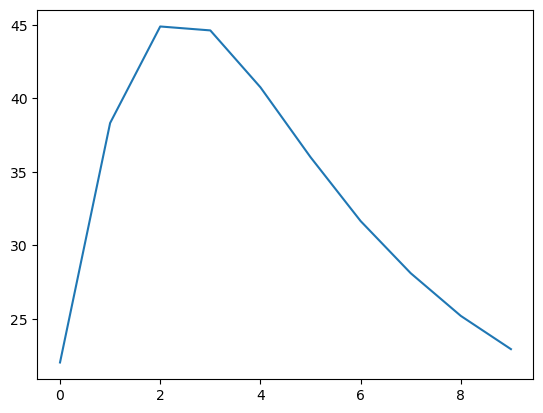

In [15]:
plt.plot(snr)
plt.show()    

Now, what you have to find is way of identifying where the curve peaks to select that as your best aperture. Sometimes the curve would show a clear maximum (like in this case) and sometimes it might flatten and does not really decay (or if it does, it happens very slowly).

Thus, do not just trust finding the maximum. It won't work in all the cases (might work in most).

In those cases without a clear peak, you would want to stop at the first aperture after which there is no much improvement if you select a larger one.

You have to repeat this process for all the images (hence the usefulness of defining a function to include all the lines and simplify the for loop)

#### Remember, you optimise the aperture for your main target in each image. The other stars within each image will have the same aperture as your main target.